In [5]:
from torch import device
from disentanglement_final.data_prep import *

data_name = "yelp"
Data = {"nli": NLIGenData2, "ontonotes": OntoGenData,
        "yelp": HuggingYelp2,
        "paranmt": ParaNMTCuratedData}[data_name]

MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE = 20, 512, 200000, device("cuda:0")
data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, False)

Dataset has 443259  examples. statistics:
 -words: 8.881732801815643+-3.6417630572571147(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:9.0,11.0,14.0,15.0,15.0)
Dataset has 4000  examples. statistics:
 -words: 8.9255+-3.668371539252806(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:9.0,11.0,14.0,15.0,15.0)
Dataset has 1000  examples. statistics:
 -words: 10.325+-2.8399603870476784(quantiles(0.5, 0.7, 0.9, 0.95, 0.99:10.0,12.0,14.0,15.0,15.0)
data loading took 5.41306209564209


In [1]:
import spacy
from supar import Parser
import itertools


const_parser = Parser.load('crf-con-en')
nlp = spacy.load("en_core_web_sm")


def get_sens(batch):
    return [' '.join([data.vocab.itos[w] for w in s ]).split('<eos>')[0] for s in batch.text[:, 1:]]
    

def get_children(tok, depth):
    if depth == 0:
        return list(tok.children)
    else:
        return list(tok.children) + \
               list(itertools.chain.from_iterable([get_children(c, depth-1) for c in tok.children]))


def truncated_template(sents, depth=0):
    docs = nlp.pipe(sents)
    templates = []
    for doc in docs:
        children = None
        for i, tok in enumerate(doc):
            if tok.dep_ =='ROOT':
                children = [tok]+get_children(tok, depth)
        if children is not None:
            sort_dict_lex = {c.i: c.text for c in children}
            sort_dict_syn = {c.i: c.dep_ for c in children}
            templates.append({'lex': ' '.join([sort_dict_lex[i] for i in sorted(sort_dict_lex.keys())]),
                              'syn': ' '.join([sort_dict_syn[i] for i in sorted(sort_dict_syn.keys())])})
        else:
            templates.append({'lex': ' ', 'syn': ' '})
    return templates    


def truncate_tree(tree, lv):
    tok_i = 0
    curr_lv = 0
    tree_toks = tree.split()
    while tok_i != len(tree_toks):
        if tree_toks[tok_i].startswith('('):
            curr_lv += 1
        else:
            closed_lvs = int(tree_toks[tok_i].count(')'))
            if curr_lv - closed_lvs <= lv:
                tree_toks[tok_i] = ')'*(closed_lvs - (curr_lv-lv))
            curr_lv -= closed_lvs
        if lv >= curr_lv and tree_toks[tok_i]!='':
            tok_i += 1
        else:
            tree_toks.pop(tok_i)
    return ' '.join(tree_toks)


def get_lin_parse_tree(sens):
    tree_parses = const_parser.predict(sens, lang='en', verbose=False)
    lin_parses = []
    for p in tree_parses:
        lin_p = repr(p)
        if lin_p.startswith("(TOP"):
            lin_p = lin_p[5:-1]
        lin_parses.append(lin_p)
    return lin_parses

def sent_templates(l1, lv):
    not_empty1 = [any([c != " " for c in li1]) for li1 in l1]
    l1 = [li1 for li1, ne1 in zip(l1, not_empty1) if ne1 ]
    docs1 = get_lin_parse_tree(l1)
    temps1 = [truncate_tree(doc, lv) for doc in docs1]
    return temps1
    
def template_match(l1, l2, lv, verbose=0, filter_empty=True):
    if filter_empty:
        not_empty1 = [any([c != " " for c in li1]) for li1 in l1]
        not_empty2 = [any([c != " " for c in li2]) for li2 in l2]
        l1 = [li1 for li1, ne1, ne2 in zip(l1, not_empty1, not_empty2) if ne1 and ne2]
        l2 = [li2 for li2, ne1, ne2 in zip(l2, not_empty1, not_empty2) if ne1 and ne2]
    docs1, docs2 = get_lin_parse_tree(l1), get_lin_parse_tree(l2)
    temps1 = [truncate_tree(doc, lv) for doc in docs1]
    temps2 = [truncate_tree(doc, lv) for doc in docs2]
    if verbose:
        for l, t in zip(l1+l2, temps1+temps2):
            print(l, "-->", t)
        print("+++++++++++++++++++++++++")
    return [int(t1 == t2) for t1, t2 in zip(temps1, temps2)]


In [132]:

for batch in data.train_iter:
    sens = get_sens(batch)
    temps = sent_templates(sens, 1)
    dep_temps = truncated_template(sens, 0)
    lim = 5
    for sen, temp, dep_temp in zip(sens[:lim], temps[:lim], dep_temps[:lim]):
        print(sen, temp, dep_temp['syn'])
    break


In [16]:
from tqdm import tqdm
def get_chain_label(tok):
    if tok.head.i != tok.i:
        return get_chain_label(tok.head)+'>'+tok.dep_
    else:
        return tok.dep_ if tok.dep_ != "ROOT" else ""


def sen_chain_labels(sens):
    return [[get_chain_label(tok)for tok in doc] for doc in nlp.pipe(sens)]

def get_corpus_structures(iter):
    chain_labs = []
    temps1, temps2 = [], []
    texts = []
    for i, batch in enumerate(tqdm(iter)):
        text = get_sens(batch)
        # chain_labs.extend(sen_chain_labels(text))
        temps1.extend(sent_templates(text, 2))
        # temps2.extend(sent_templates(text, 3))
        texts.extend(text)
        #if i==10:break
    return chain_labs, temps1, temps2, texts
    

In [17]:
chain_labs, temps1, temps2, texts = get_corpus_structures(data.test_iter)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:01<00:21,  1.14s/it]

 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

 15%|█▌        | 3/20 [00:03<00:17,  1.04s/it]

 20%|██        | 4/20 [00:03<00:16,  1.01s/it]

 25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]

 30%|███       | 6/20 [00:05<00:13,  1.04it/s]

 35%|███▌      | 7/20 [00:06<00:12,  1.05it/s]

 40%|████      | 8/20 [00:07<00:11,  1.07it/s]

 45%|████▌     | 9/20 [00:08<00:10,  1.08it/s]

 50%|█████     | 10/20 [00:09<00:09,  1.07it/s]

 55%|█████▌    | 11/20 [00:10<00:08,  1.08it/s]

 60%|██████    | 12/20 [00:11<00:07,  1.09it/s]

 65%|██████▌   | 13/20 [00:12<00:06,  1.10it/s]

 70%|███████   | 14/20 [00:13<00:05,  1.09it/s]

 75%|███████▌  | 15/20 [00:14<00:04,  1.09it/s]

 80%|████████  | 16/20 [00:14<00:03,  1.09it/s]

 85%|████████▌ | 17/20 [00:15<00:02,  1.09it/s]

 90%|█████████ | 18/20 [00:16<00:01,  1.10it/s]

 95%|█████████▌| 19/20 [00:17<00:00,  1.10it/s]

100%|██████████| 20/20 [00:18<00:00,  1.15it/s]

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]

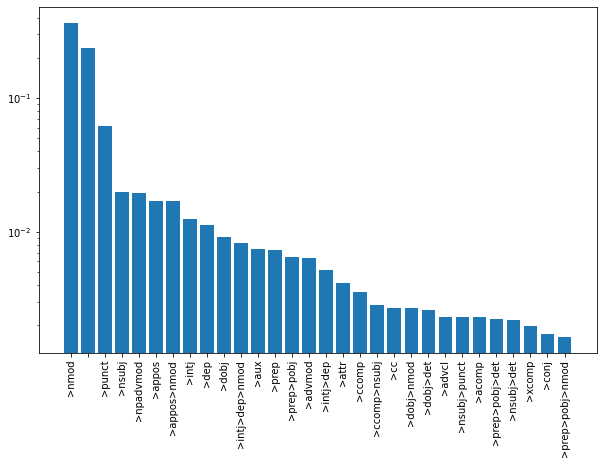

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

flat_chain_l = list(itertools.chain.from_iterable(chain_labs))
def my_hist(l, n=10, start=0):
    labels, counts = np.unique(l, return_counts=True)
    arg_sort_idx = np.argsort(-counts)
    labels, counts = labels[arg_sort_idx], counts[arg_sort_idx]
    ticks = range(len(counts[start:n]))
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom=0.4)
    plt.bar(ticks, counts[start:n]/sum(counts), align='center', log=True)
    plt.xticks(ticks, labels[start:n], rotation='vertical')
    plt.savefig("para_deps.jpg")
# plt.clf()
# plt.xticks(rotation='vertical')
# plt.hist(flat_chain_l[:50], density=True, rwidth=0.95)
my_hist(flat_chain_l, 30, 0)

In [11]:

def top_elements(l, n=30, start=0):
    labels, counts = np.unique(l,return_counts=True)
    arg_sort_idx = np.argsort(-counts)
    labels, counts = labels[arg_sort_idx], counts[arg_sort_idx]
    return {"elements": labels[start:n].tolist(), "counts":counts[start:n].tolist()}

to_dump = {"para": {"top_deps":top_elements(flat_chain_l),
         "top_temps1":top_elements(temps1),
         "top_temps2":top_elements(temps2)}}
print(to_dump)

{'para': {'top_deps': {'elements': ['>nmod', '', '>punct', '>nsubj', '>npadvmod', '>appos', '>appos>nmod', '>intj', '>dep', '>dobj', '>intj>dep>nmod', '>aux', '>prep', '>prep>pobj', '>advmod', '>intj>dep', '>attr', '>ccomp', '>ccomp>nsubj', '>cc', '>dobj>nmod', '>dobj>det', '>advcl', '>nsubj>punct', '>acomp', '>prep>pobj>det', '>nsubj>det', '>xcomp', '>conj', '>prep>pobj>nmod'], 'counts': [153104, 99784, 26090, 8313, 8134, 7166, 7134, 5250, 4701, 3863, 3447, 3118, 3075, 2736, 2681, 2167, 1731, 1499, 1190, 1136, 1128, 1093, 970, 968, 964, 930, 925, 832, 719, 684]}, 'top_temps1': {'elements': ['(S (NP ) (VP ) (_ ))', '(S (VP ))', '(NP (NP ) (_ ) (NP ) (_ ))', '(S (NP ) (VP ))', '(S (_ ) (NP ) (VP ) (_ ))', '(S (VP ) (_ ))', '(SQ (SQ ) (NP ) (_ ))', '(S (S ) (_ ) (S ) (_ ))', '(NP (NP ) (VP ) (_ ))', '(S (NP ) (ADVP ) (VP ) (_ ))', '(SQ (SQ ) (FRAG ) (_ ))', '(S (ADVP ) (NP ) (VP ) (_ ))', '(SBARQ (SBARQ ) (NP ) (_ ))', '(S (S ) (_ ) (NP ) (_ ))', '(S (INTJ ) (_ ) (NP ) (VP ) (_ ))', '(S 

In [14]:
import json
with open("data_struct_stats.json", "r") as f:
    past = json.load(f)
with open("data_struct_stats.json", "w") as f:
    json.dump({**past, **to_dump}, f,)

In [29]:
entropies = {'nli': {"deps": None, "temps1": None, "temps2": None},
             'para': {"deps": None, "temps1": None, "temps2": None},
             'yelp': {"deps": None, "temps1": None, "temps2": None},
             }
for dat in entropies.keys():
    for el in entropies[dat].keys():
        ps = past[dat]['top_'+el]['counts'][:30]
        ps = [p/sum(ps) for p in ps]
        entropies[dat][el] = sum([-np.log(p)*p for p in ps])
for ent_t in {"deps", "temps1", "temps2"}:
    print(ent_t, " entropies:")
    print({dat:entropies[dat][ent_t] for dat in entropies.keys()})


temps2  entropies:
{'nli': 2.6712027567729724, 'para': 2.733299334760176, 'yelp': 3.084666451875326}
temps1  entropies:
{'nli': 0.6269452592294088, 'para': 1.8634116385192814, 'yelp': 2.1876271584244344}
deps  entropies:
{'nli': 2.83254427277654, 'para': 1.8095300498114684, 'yelp': 1.769511220997608}


In [4]:
import json, numpy as np
with open("data_struct_stats.json", "r") as f:
    past = json.load(f)
entropies = {'nli': {"deps": None, "temps1": None, "temps2": None},
             'para': {"deps": None, "temps1": None, "temps2": None},
             'yelp': {"deps": None, "temps1": None, "temps2": None},
             }
for dat in entropies.keys():
    for el in entropies[dat].keys():
        ps = past[dat]['top_'+el]['counts'][:8]
        ps = [p/sum(ps) for p in ps]
        entropies[dat][el] = sum([-np.log(p)*p for p in ps])
for ent_t in ["deps", "temps1", "temps2"]:
    print(ent_t, " entropies:")
    print({dat:entropies[dat][ent_t] for dat in entropies.keys()})


deps  entropies:
{'nli': 2.0017677358487775, 'para': 1.3515890460640447, 'yelp': 1.2897547139684127}
temps1  entropies:
{'nli': 0.48023002437586537, 'para': 1.188846813358554, 'yelp': 1.324838723929663}
temps2  entropies:
{'nli': 1.7157022064980025, 'para': 1.748614722062475, 'yelp': 1.9521028809868068}


In [8]:
r1, r2 = 0, 100
for temp, text in zip(temps1[r1:r2], texts[r1:r2]):
    if temp == '(S (NP ) (VP ) (_ ))':
        print(text.replace('<pad>', '').strip()+'')

it is not worth the so called savings !
it is a shame that all were so bland .
i will not be back !
there is a difference between a chain and real mom and pop donut shop .
i could n't agree with david more .
it 's that good .
i liked it a lot .
the restaurant is an older quaint building which is nice and fun .
i 'm not sure i can try the place again .
this is how its done !
the service was very friendly and professional .
carpets in rooms and common area are dirty as well .
this restaurant has a lovely atmosphere .
it 's one of the places i like to take visiting friends and family .
he talked loudly across the whole restaurant to staff members back in the kitchen .
we absolutely love this place .
atmosphere is inviting and comfortable .
we had a great time visiting arizona .
she was cracking jokes and making comments that were borderline inappropriate .
i love the `` local '' at home feel of this place !
this place sucks .
the store is kept very clean , and is organized well .
that 's 

In [18]:
from tqdm import tqdm
# with open("whole_parses_yelp_train.tsv", 'w') as f:
#     for temp, text in tqdm(zip(temps1, texts)):
#         f.write(text.replace('<pad>', '').strip()+'\t'+temp+'\n')
with open(".data\\yelp_reg\\test.tsv", 'w') as f:
    for temp, text in tqdm(zip(temps1, texts)):
        if temp == '(S (NP ) (VP ) (_ ))':
            f.write(text.replace('<pad>', '').strip()+'\n')

0it [00:00, ?it/s]

1000it [00:00, 333649.19it/s]